# SHAP 분석

## 라이브러리

In [3]:
# library import
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import lightgbm as lgb  # 없을 경우 cmd/anaconda prompt에서 install
from math import sqrt
from sklearn.metrics import mean_squared_error


In [4]:
import matplotlib.pyplot as plt
import matplotlib
import shap

# macOS에서 한글 폰트 설정 (AppleGothic 또는 NanumGothic)
matplotlib.rcParams['font.family'] = 'AppleGothic'  # 또는 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 제대로 표시

## 데이터 읽어오기

In [6]:
path = r"/Users/ihyeonseo/Desktop//  ꒰⍢꒱ ༘*/DEBA/인공지능기반의사결정/data/분석준비완료.csv"
df = pd.read_csv(path)

In [7]:
df

,성별,연령,학력별,월 가구소득,수도권/비수도권,건강에 대한 자신감,취업구분,직업 관련 목표지향,학습 지향,사회학습 참여,평생학습 효과성,평생학습 접근성,참여여부
0,1,1.0,3,3,1.0,1,1,3.666667,4.00,1.000000,3.75,2,1
1,2,1.0,3,3,1.0,1,1,4.333333,3.75,1.000000,3.75,1,1
2,2,2.0,3,4,1.0,1,1,3.666667,3.50,1.000000,3.50,2,1
3,1,2.0,3,4,1.0,1,1,3.666667,3.75,1.333333,3.75,2,1
4,2,4.0,1,4,1.0,1,1,3.666667,3.75,1.000000,3.50,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51364,2,3.0,3,3,1.0,2,2,3.666667,3.00,1.000000,3.00,1,1
51365,1,5.0,1,2,1.0,1,2,3.333333,3.25,1.333333,2.50,2,1
51366,2,5.0,1,2,1.0,1,2,3.333333,3.50,1.333333,2.50,2,1
51367,2,5.0,1,3,1.0,1,2,3.333333,3.50,1.333333,2.50,2,1


In [8]:
# shape 파악
nCar = df.shape[0] # 데이터 개수
nVar = df.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 51369 nVar: 13


In [9]:
feature_columns = list(df.columns.difference(['참여여부'])) # price-target, 그 외 feature
X = df[feature_columns]
y = df['참여여부']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42) 
# train/test 비율을 7:3
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 확인

(35958, 12) (15411, 12) (35958,) (15411,)


## Shap Value 실습을 위한 LightGBM 모델 구현

In [11]:
# lightgbm model
lgb_dtrain = lgb.Dataset(data = train_x, label = train_y) # LightGBM 모델에 맞게 변환
lgb_param = {'max_depth': 10,
            'learning_rate': 0.01, # Step Size
            'n_estimators': 1000, # Number of trees
            'objective': 'regression'} # 목적 함수 (L2 Loss)
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
lgb_model_predict = lgb_model.predict(test_x) # test data 예측
print("RMSE: {}".format(sqrt(mean_squared_error(lgb_model_predict, test_y)))) # RMSE

[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train s

/opt/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE: 0.26275423612441745


## Shap Value 구현 & 시각화

In [13]:
# shap value를 이용하여 각 변수의 영향도 파악

# !pip install shap (에러 발생시, skimage version 확인 (0.14.2 이상 권장))
# import skimage -> skimage.__version__ (skimage version 확인)
# skimage version upgrade -> !pip install --upgrade scikit-image

# shap value 
import shap
explainer = shap.TreeExplainer(lgb_model) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(test_x) # Shap Values 계산

In [14]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], test_x.iloc[1,:])

In [15]:
from tqdm import tqdm
import shap

for i in tqdm(range(len(test_x))):
    shap.force_plot(explainer.expected_value, shap_values[i], test_x.iloc[i])

100%|██████████████████████████████████| 15411/15411 [00:00<00:00, 23230.46it/s]


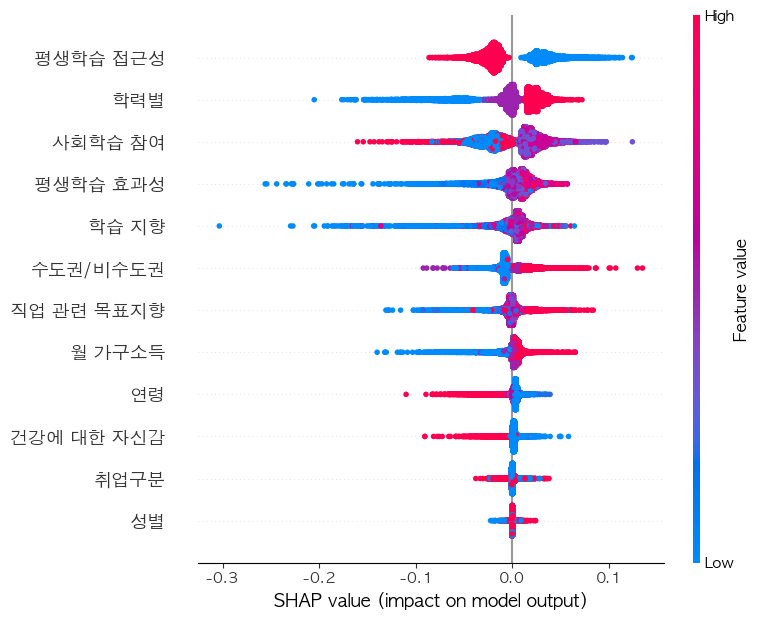

In [16]:
# summary
shap.summary_plot(shap_values, test_x)

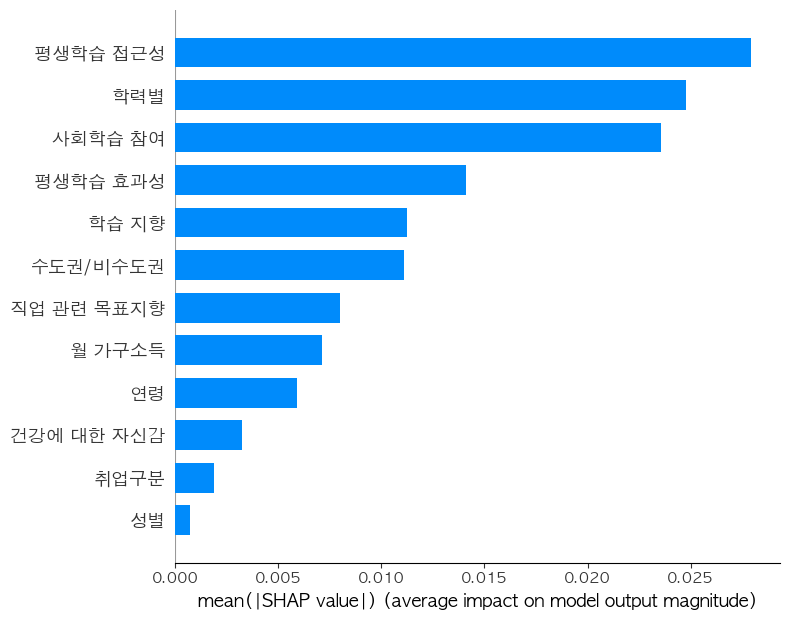

In [17]:
 # 각 변수에 대한 |Shap Values|을 통해 변수 importance 파악
shap.summary_plot(shap_values, test_x, plot_type = "bar")

Accuracy: 0.9171
Precision: 0.9193
Recall: 0.9969
F1 Score: 0.9565
Confusion Matrix:
[[   68  1234]
 [   44 14065]]
AUC: 0.7802


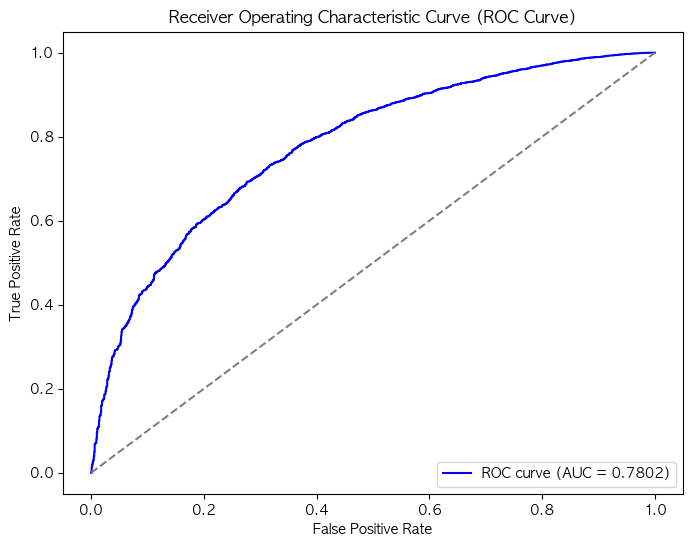

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 예측값을 확률로 변환 (이진 분류인 경우)
lgb_model_predict_prob = lgb_model.predict(test_x)  # 확률로 예측값
lgb_model_predict_binary = (lgb_model_predict_prob > 0.5).astype(int)  # 임계값 0.5 이상이면 1, 이하이면 0으로 분류

# 성과 지표 계산
accuracy = accuracy_score(test_y, lgb_model_predict_binary)
precision = precision_score(test_y, lgb_model_predict_binary)
recall = recall_score(test_y, lgb_model_predict_binary)
f1 = f1_score(test_y, lgb_model_predict_binary)
conf_matrix = confusion_matrix(test_y, lgb_model_predict_binary)

# 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# AUC와 ROC Curve
auc = roc_auc_score(test_y, lgb_model_predict_prob)
fpr, tpr, thresholds = roc_curve(test_y, lgb_model_predict_prob)

print(f"AUC: {auc:.4f}")

# ROC Curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (ROC Curve)')
plt.legend(loc="lower right")
plt.show()
